Challenge Problem: Monet Style Transfer Using GANs
The goal of this challenge is to create a Generative Adversarial Network (GAN), specifically a CycleGAN, that transforms photographic images into the artistic style of Claude Monet's paintings.The generator part of the GAN learns to convert photos into Monet-style paintings, while the discriminator distinguishes between real Monet paintings and generated ones. The challenge evaluates the model's performance based on how well the generated images resemble Monet's style.

Dataset Description:
The dataset contains images of two distinct types:

Monet Paintings
Photographs
The images are provided in two formats: TFRecord files and JPEG files, which store the same image content but in different formats.

1. Monet Paintings:
Contains 300 Monet paintings.
Images are of size 256x256 pixels and in RGB format (3 channels).
Provided in both TFRecord and JPEG formats.
2. Photographs:
Contains 7,038 photographs.
Images are also of size 256x256 pixels in RGB format.
Provided in both TFRecord and JPEG formats.


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import PIL

# Paths to the TFRecord files
monet_tfrecord_path = "C:/Users/srine/Downloads/gan-getting-started/monet_tfrec/*.tfrec"
photo_tfrecord_path = "C:/Users/srine/Downloads/gan-getting-started/photo_tfrec/*.tfrec"

# Function to parse TFRecord files
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Load and parse the datasets with a small batch size
def load_dataset(tfrecords_path, batch_size=1):
    raw_dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecords_path))
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
    return parsed_dataset.batch(batch_size)

# Load Monet and Photo datasets with batch size of 1
monet_ds = load_dataset(monet_tfrecord_path, batch_size=1)
photo_ds = load_dataset(photo_tfrecord_path, batch_size=1)

# Prefetch data for better performance
monet_ds = monet_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
photo_ds = photo_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

We will do some EDA to find Image Shapes, View Samples from Both Datasets and analyze Pixel Value Distributions

In [25]:
# Function to get shape of images
def get_image_shapes(dataset, num_samples=5):
    shapes = []
    for image_batch in dataset.take(num_samples):
        for img in image_batch:
            shapes.append(img.shape)
    return shapes

# Get image shapes for both datasets
monet_shapes = get_image_shapes(monet_ds)
photo_shapes = get_image_shapes(photo_ds)

print("Monet Dataset Image Shapes:", monet_shapes)
print("Photo Dataset Image Shapes:", photo_shapes)

Monet Dataset Image Shapes: [TensorShape([256, 256, 3]), TensorShape([256, 256, 3]), TensorShape([256, 256, 3]), TensorShape([256, 256, 3]), TensorShape([256, 256, 3])]
Photo Dataset Image Shapes: [TensorShape([256, 256, 3]), TensorShape([256, 256, 3]), TensorShape([256, 256, 3]), TensorShape([256, 256, 3]), TensorShape([256, 256, 3])]


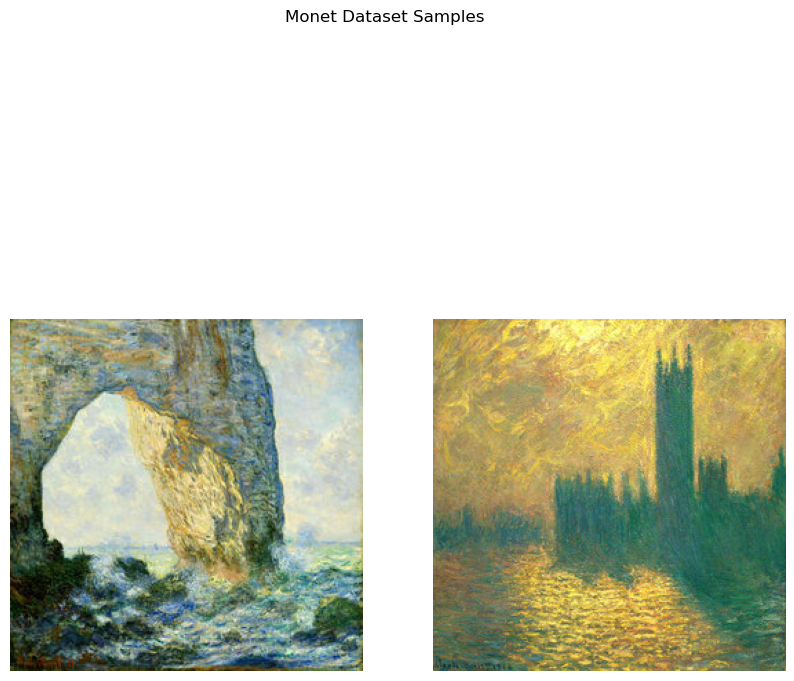

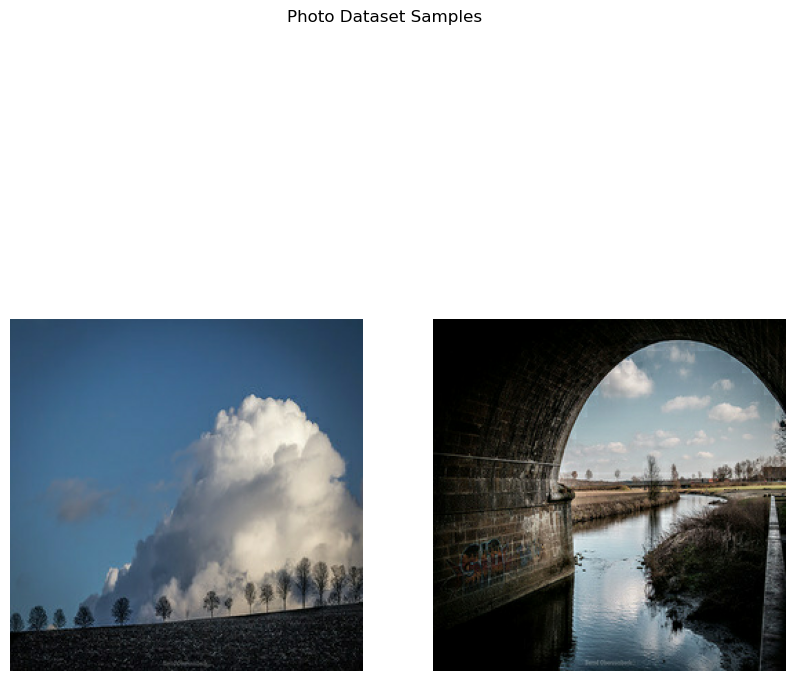

In [31]:
# Function to display samples from a dataset
def display_samples(dataset, num_samples=2, title="Dataset Samples"):
    plt.figure(figsize=(10, 10))
    for i, img_batch in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i + 1)
        img = (img_batch[0].numpy() * 127.5 + 127.5).astype(np.uint8)  # Rescale to [0, 255]
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Display samples from Monet dataset
display_samples(monet_ds, num_samples=2, title="Monet Dataset Samples")

# Display samples from Photo dataset
display_samples(photo_ds, num_samples=2, title="Photo Dataset Samples")

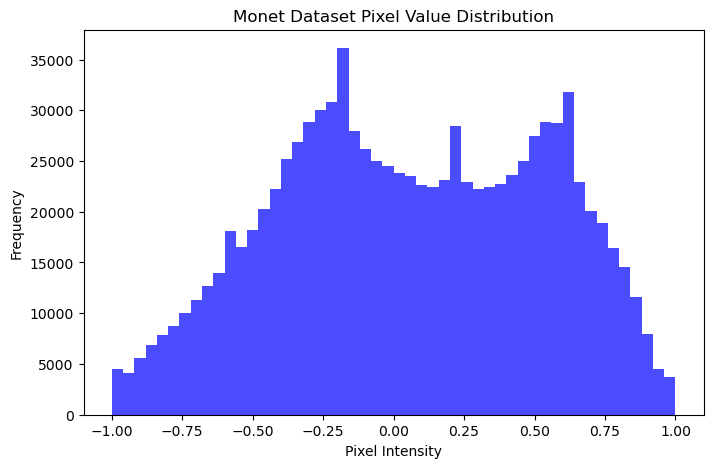

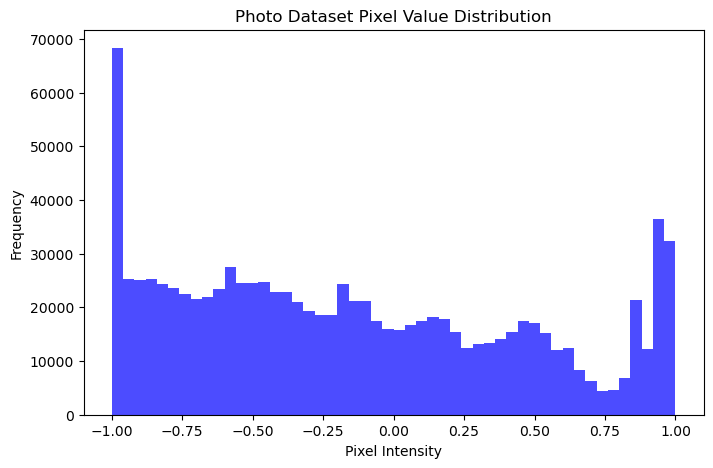

In [33]:
# Function to plot pixel value distributions
def plot_pixel_distribution(dataset, num_samples=5, title="Pixel Value Distribution"):
    pixel_values = []
    for image_batch in dataset.take(num_samples):
        img = image_batch[0].numpy()
        pixel_values.extend(img.flatten())

    plt.figure(figsize=(8, 5))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Plot pixel distribution for Monet dataset
plot_pixel_distribution(monet_ds, num_samples=5, title="Monet Dataset Pixel Value Distribution")

# Plot pixel distribution for Photo dataset
plot_pixel_distribution(photo_ds, num_samples=5, title="Photo Dataset Pixel Value Distribution")


All images in both the Monet and Photo datasets have a uniform shape of 256x256 pixels with 3 color channels (RGB) no resizing or reshaping is required during training.

Overview of the Approach:
CycleGAN architecture is employed. A CycleGAN uses two generators and two discriminators:

Generator: Transforms photos into Monet-style paintings.
Discriminator: Distinguishes between real Monet paintings and generated ones.
Cycle Consistency Loss: Ensures that converting a photo to a Monet painting and back recovers the original image.
This cyclical structure allows for effective style transfer between unpaired images, making CycleGAN suitable for this task 
where paired photo-painting datasets aren't available.

We will now build generator and descriminator functions

In [37]:
# Simplified model for memory management
kernel_init = tf.random_normal_initializer(0., 0.02)

def downsample(filters, kernel_size, strides=2, apply_batchnorm=True):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer=kernel_init, use_bias=False))
    if apply_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    return model

def upsample(filters, kernel_size, strides=2, apply_batchnorm=True, apply_dropout=False):
    model = tf.keras.Sequential()
    model.add(layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same', kernel_initializer=kernel_init, use_bias=False))
    if apply_batchnorm:
        model.add(layers.BatchNormalization())
    if apply_dropout:
        model.add(layers.Dropout(0.5))
    model.add(layers.ReLU())
    return model

def residual_block(filters):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters, kernel_size=3, padding='same', kernel_initializer=kernel_init, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    return model

# Generator model with reduced residual blocks
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])
    x = layers.Conv2D(64, 7, padding='same', kernel_initializer=kernel_init)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Downsample
    for filters in [128, 256]:
        x = downsample(filters, 3)(x)

    # Reduced residual blocks
    for _ in range(3):
        residual = x
        x = residual_block(256)(x)
        x = layers.add([x, residual])

    # Upsample
    for filters in [128, 64]:
        x = upsample(filters, 3)(x)

    # Output layer
    outputs = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)

# Discriminator model
def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])
    x = downsample(64, 4, apply_batchnorm=False)(inputs)
    for filters in [128, 256]:  # Reduced complexity
        x = downsample(filters, 4)(x)
    outputs = layers.Conv2D(1, 4, strides=1, padding='same')(x)
    return tf.keras.Model(inputs, outputs)

In [39]:
# Loss functions for Generators and Discriminators
def generator_loss_fn(fake):
    return tf.keras.losses.MeanSquaredError()(tf.ones_like(fake), fake)

def discriminator_loss_fn(real, fake):
    real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Cycle and identity loss functions
def cycle_loss_fn(real_image, cycled_image):
    return tf.keras.losses.MeanAbsoluteError()(real_image, cycled_image) * 10.0

def identity_loss_fn(real_image, same_image):
    return tf.keras.losses.MeanAbsoluteError()(real_image, same_image) * 0.5

In [9]:
# CycleGAN model
class CycleGan(tf.keras.Model):
    def __init__(self, monet_gen, photo_gen, monet_disc, photo_disc):
        super().__init__()
        self.monet_gen = monet_gen
        self.photo_gen = photo_gen
        self.monet_disc = monet_disc
        self.photo_disc = photo_disc

    def compile(self, monet_gen_optimizer, photo_gen_optimizer, monet_disc_optimizer, photo_disc_optimizer):
        super().compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        with tf.GradientTape(persistent=True) as tape:
            # Monet generator
            fake_monet = self.monet_gen(real_photo, training=True)
            cycled_photo = self.photo_gen(fake_monet, training=True)

            # Photo generator
            fake_photo = self.photo_gen(real_monet, training=True)
            cycled_monet = self.monet_gen(fake_photo, training=True)

            # Discriminator outputs
            disc_fake_monet = self.monet_disc(fake_monet, training=True)
            disc_real_monet = self.monet_disc(real_monet, training=True)

            disc_fake_photo = self.photo_disc(fake_photo, training=True)
            disc_real_photo = self.photo_disc(real_photo, training=True)

            # Generator losses
            monet_gen_loss = generator_loss_fn(disc_fake_monet) + cycle_loss_fn(real_monet, cycled_monet) + identity_loss_fn(real_monet, fake_monet)
            photo_gen_loss = generator_loss_fn(disc_fake_photo) + cycle_loss_fn(real_photo, cycled_photo) + identity_loss_fn(real_photo, fake_photo)

            # Discriminator losses
            monet_disc_loss = discriminator_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = discriminator_loss_fn(disc_real_photo, disc_fake_photo)

        # Apply gradients
        monet_gen_grads = tape.gradient(monet_gen_loss, self.monet_gen.trainable_variables)
        self.monet_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.monet_gen.trainable_variables))

        photo_gen_grads = tape.gradient(photo_gen_loss, self.photo_gen.trainable_variables)
        self.photo_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.photo_gen.trainable_variables))

        monet_disc_grads = tape.gradient(monet_disc_loss, self.monet_disc.trainable_variables)
        self.monet_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.monet_disc.trainable_variables))

        photo_disc_grads = tape.gradient(photo_disc_loss, self.photo_disc.trainable_variables)
        self.photo_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.photo_disc.trainable_variables))

        return {
            'monet_gen_loss': monet_gen_loss,
            'photo_gen_loss': photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }


# Instantiate models and optimizers
monet_gen = build_generator()
photo_gen = build_generator()
monet_disc = build_discriminator()
photo_disc = build_discriminator()

# Compile the CycleGAN
cycle_gan = CycleGan(monet_gen, photo_gen, monet_disc, photo_disc)
cycle_gan.compile(
    monet_gen_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    photo_gen_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    monet_disc_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    photo_disc_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
)

monet_ds_size = len(list(monet_ds))  # Size of Monet dataset
photo_ds_size = len(list(photo_ds))  # Size of Photo dataset

print(f"Monet dataset size: {monet_ds_size}")
print(f"Photo dataset size: {photo_ds_size}")

steps_per_epoch = monet_ds_size  # Or photo_ds_size if you want to use the size of the photo dataset

# Train the model
cycle_gan.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=10, steps_per_epoch=50)



Monet dataset size: 300
Photo dataset size: 7038
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 504s 9s/step - monet_disc_loss: 0.5854 - monet_gen_loss: 4.6694 - photo_disc_loss: 0.5652 - photo_gen_loss: 4.8706
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 461s 9s/step - monet_disc_loss: 0.2848 - monet_gen_loss: 3.5547 - photo_disc_loss: 0.2856 - photo_gen_loss: 4.2028
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 468s 9s/step - monet_disc_loss: 0.2717 - monet_gen_loss: 3.4504 - photo_disc_loss: 0.2716 - photo_gen_loss: 4.2166
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 473s 9s/step - monet_disc_loss: 0.2682 - monet_gen_loss: 3.6069 - photo_disc_loss: 0.2619 - photo_gen_loss: 3.6878
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 511s 10s/step - monet_disc_loss: 0.2615 - monet_gen_loss: 3.2363 - photo_disc_loss: 0.2565 - photo_gen_loss: 3.4858
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 498s 10s/step - monet_disc_loss: 0.2549 - monet_gen_loss: 3.4510 - photo_disc_loss: 0.2457 - photo_gen_loss: 3.8084
Epoch 7/10
50/50 ━━━━━━━━━━━━━━

C:\Users\srine\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 430s 9s/step - monet_disc_loss: 0.2578 - monet_gen_loss: 3.4112 - photo_disc_loss: 0.2546 - photo_gen_loss: 3.8700
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 428s 9s/step - monet_disc_loss: 0.2525 - monet_gen_loss: 3.2265 - photo_disc_loss: 0.2543 - photo_gen_loss: 3.9198
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 435s 9s/step - monet_disc_loss: 0.2549 - monet_gen_loss: 3.2009 - photo_disc_loss: 0.2533 - photo_gen_loss: 3.9406


Result analysis:
The discriminator loss for Monet-style images starts at 0.5854 in Epoch 1 and steadily decreases to 0.2549 by Epoch 10.
This steady reduction in loss indicates that the discriminator is becoming more confident in distinguishing between real Monet paintings and the generated ones. A lower discriminator loss means that it is doing a better job at classifying real vs. fake images.

Similarly, the discriminator loss for the photo dataset starts at 0.5652 in Epoch 1 and decreases to 0.2533 by Epoch 10.
This reduction in loss shows that the photo discriminator is also improving at distinguishing real photos from generated ones.

Discriminator Performance: The discriminators have improved significantly over the course of training, with both the Monet and photo discriminators becoming better at distinguishing between real and generated images.

Generator Performance: The generators have also improved, but they still exhibit relatively high losses. The model is learning to generate Monet-style paintings, but there is still room for improvement in producing highly realistic Monet-like images from photos. The model may need additional epochs of training or further tuning of the model architecture or hyperparameters.

Let us generate the images now

In [17]:
import PIL
import os

# Directory to save generated images
output_dir = "C:/Users/srine/Downloads/gan-getting-started/generated_images1"
os.makedirs(output_dir, exist_ok=True)

# Set the number of images you want to generate
num_images_to_generate = 7000  # Adjust this as needed

# Generate Monet-style images using the trained generator
for i, photo_batch in enumerate(photo_ds.take(num_images_to_generate)):
    generated_monet = monet_gen(photo_batch, training=False)[0].numpy()
    
    # Rescale the image back to the range [0, 255]
    generated_monet = (generated_monet * 127.5 + 127.5).astype(np.uint8)
    
    # Convert to a PIL Image and save
    img = PIL.Image.fromarray(generated_monet)
    img.save(os.path.join(output_dir, f"image_{i + 1}.jpg"))

    # Print progress every 10 images
    if (i + 1) % 10 == 0 or i + 1 == num_images_to_generate:
        print(f"{i + 1}/{num_images_to_generate} images generated.")

print(f"{num_images_to_generate} Monet-style images generated and saved to {output_dir}.")


10/7000 images generated.
20/7000 images generated.
30/7000 images generated.
40/7000 images generated.
50/7000 images generated.
60/7000 images generated.
70/7000 images generated.
80/7000 images generated.
90/7000 images generated.
100/7000 images generated.
110/7000 images generated.
120/7000 images generated.
130/7000 images generated.
140/7000 images generated.
150/7000 images generated.
160/7000 images generated.
170/7000 images generated.
180/7000 images generated.
190/7000 images generated.
200/7000 images generated.
210/7000 images generated.
220/7000 images generated.
230/7000 images generated.
240/7000 images generated.
250/7000 images generated.
260/7000 images generated.
270/7000 images generated.
280/7000 images generated.
290/7000 images generated.
300/7000 images generated.
310/7000 images generated.
320/7000 images generated.
330/7000 images generated.
340/7000 images generated.
350/7000 images generated.
360/7000 images generated.
370/7000 images generated.
380/7000 i

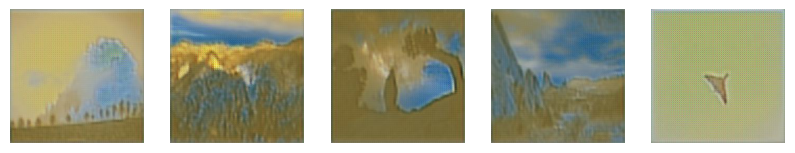

In [21]:
#Path to the directory containing the generated images
generated_images_dir = "C:/Users/srine/Downloads/gan-getting-started/generated_images1"

# Get a list of all image files in the directory
image_files = sorted([f for f in os.listdir(generated_images_dir) if f.endswith(".jpg")])

# Number of images to display
num_images_to_display = 5  # Adjust the number to display more or fewer images

# Plot and display the images
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    img_path = os.path.join(generated_images_dir, image_files[i])
    img = PIL.Image.open(img_path)
    
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

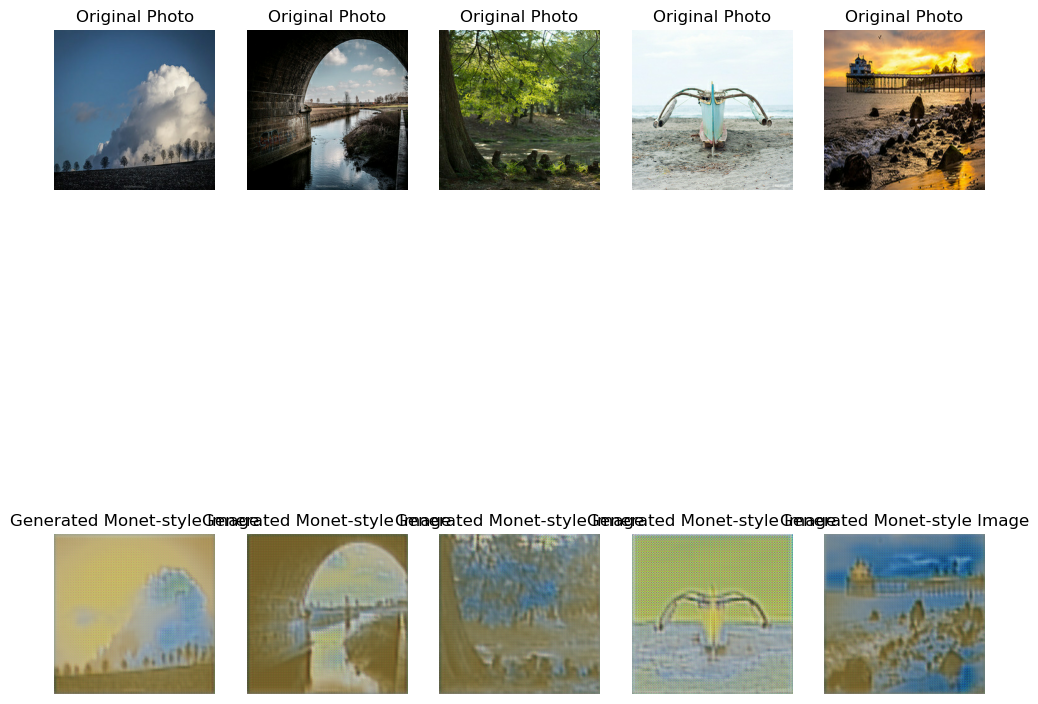

In [41]:
# Display original photos and generated Monet-style images side by side
def display_generated_vs_original(photo_dataset, generator_model, num_samples=5):
    plt.figure(figsize=(12, 12))
    for i, photo_batch in enumerate(photo_dataset.take(num_samples)):
        # Original photo
        photo = (photo_batch[0].numpy() * 127.5 + 127.5).astype(np.uint8)

        # Generate Monet-style image
        generated_monet = generator_model(photo_batch, training=False)[0].numpy()
        generated_monet = (generated_monet * 127.5 + 127.5).astype(np.uint8)

        # Plot both images side by side
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(photo)
        plt.axis('off')
        plt.title("Original Photo")

        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(generated_monet)
        plt.axis('off')
        plt.title("Generated Monet-style Image")

    plt.show()

# Assuming you have the trained generator model (monet_gen)
display_generated_vs_original(photo_ds, monet_gen, num_samples=5)


CONCLUSION: We have successfully used Monet paintings to train the model and generated the monet style images for photos. Cycle GAN worked pretty good. More epochs may be needed for training but they could run longer.